### Required Libraries and Imports

In [ ]:
!pip install git+https://github.com/kartikgill/taco-box

  Cloning https://github.com/kartikgill/taco-box to /tmp/pip-req-build-vpkwdz1e
  Running command git clone --filter=blob:none --quiet https://github.com/kartikgill/taco-box /tmp/pip-req-build-vpkwdz1e
  Resolved https://github.com/kartikgill/taco-box to commit 41d1e6977d0f5dc1d5bd1b508318afd086bdd1e5
  Preparing metadata (setup.py) ... done
  Created wheel for taco-box: filename=taco_box-0.1.1-py3-none-any.whl size=8024 sha256=e8cf4b98918452b44e905c75aa2463084dd5cc3bbd14dc6c9d180de73146c7dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-b8ud2aq5/wheels/62/e1/44/6da2effbc2ff5f6f20214f4adbf76e51409f7b4fb610a7d393
Successfully built taco-box


In [ ]:
!pip install evaluate
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import cv2
from tacobox import Taco
import random

from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch import Tensor
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from transformers import RobertaTokenizerFast, GPT2Tokenizer
from transformers import RobertaConfig, EncoderDecoderConfig, EncoderDecoderModel
from transformers import GPT2Config, GPT2LMHeadModel

from jiwer import cer
from evaluate import load
cer = load("cer")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Dataset
The dataset should be in following format:
![image.png](attachment:image.png)

In [ ]:
import os
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split

# Define paths to your zip files
image_zip_path = "/content/Images.zip"
label_zip_path = "/content/Labels.zip"
output_dir = "/content/dataset"  # Directory to store extracted data

# Step 1: Extract images and labels
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extract images and labels
image_dir = os.path.join(output_dir, "images")
label_dir = os.path.join(output_dir, "labels")
os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

extract_zip(image_zip_path, image_dir)
extract_zip(label_zip_path, label_dir)

# Step 2: Match images and labels
data = []
missing_labels = 0
missing_labels_threshold = 5  # Stop if more than 5 labels are missing

for img_name in sorted(os.listdir(image_dir)):  # Sort to align files if naming is consistent
    img_path = os.path.join(image_dir, img_name)
    label_name = os.path.splitext(img_name)[0] + ".txt"  # Assuming same base name for labels
    label_path = os.path.join(label_dir, label_name)

    if os.path.exists(label_path):
        with open(label_path, 'r', encoding="utf-8") as label_file:
            label_text = label_file.read().strip()
        data.append({"file_name": img_path, "text": label_text})
    else:
        missing_labels += 1
        print(f"Label not found for image: {img_name}")
        if missing_labels > missing_labels_threshold:
            print(f"Stopping because too many labels are missing.")
            break

print(f"Total missing labels: {missing_labels}")

# Step 3: Create a DataFrame and save to CSV
df = pd.DataFrame(data)
csv_path = os.path.join(output_dir, "dataset.csv")
df.to_csv(csv_path, index=False)
print(f"Dataset CSV saved to {csv_path}")

# Step 4: Inspect the first few rows of the CSV to ensure correct data
print("First few rows of the dataset:")
print(df.head())

# Step 5: Split into train, eval, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
eval_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save splits to separate CSV files
train_csv_path = os.path.join(output_dir, "train.csv")
eval_csv_path = os.path.join(output_dir, "eval.csv")
test_csv_path = os.path.join(output_dir, "test.csv")

train_df.to_csv(train_csv_path, index=False)
eval_df.to_csv(eval_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print("Data split into train, eval, and test sets.")
print(f"Train set size: {len(train_df)}, Eval set size: {len(eval_df)}, Test set size: {len(test_df)}")

# Step 6: Verify that the splits have correct data
print("First few rows of the train set:")
print(train_df.head())

print("First few rows of the eval set:")
print(eval_df.head())

print("First few rows of the test set:")
print(test_df.head())



Total missing labels: 0
Dataset CSV saved to /content/dataset/dataset.csv
First few rows of the dataset:
                           file_name  \
0      /content/dataset/images/1.jpg   
1     /content/dataset/images/10.jpg   
2    /content/dataset/images/100.jpg   
3   /content/dataset/images/1000.jpg   
4  /content/dataset/images/10000.jpg   

                                                text  
0     اور تھیٹر میں' پھر ایسٹ انڈیا کمپنی نے اودھ پر  
1  چاول غیر ملکی زر مبادلہ حاصل کرنے والی اجناس م...  
2  ٹیکس کلچر کا فروغ ملکی ترقی کے لیے اتنہائی ضرو...  
3  ہے۔ جبکہ دائیں بازو کی جماعتیں بھی مقبولیت حاص...  
4  لیں تو ہم ملک میں ڈھائی سو اسپتال بناسکتے ہیں ...  
Data split into train, eval, and test sets.
Train set size: 14616, Eval set size: 1827, Test set size: 1827
First few rows of the train set:
                               file_name  \
16887   /content/dataset/images/8754.jpg   
2088   /content/dataset/images/11878.jpg   
11807   /content/dataset/images/4181.jpg   
6024   

In [ ]:
# HIBA EDIT HERE: Added paths
train_df = pd.read_csv("/content/dataset/train.csv")
eval_df = pd.read_csv("/content/dataset/eval.csv")
test_df = pd.read_csv("/content/dataset/test.csv")
train_df.head()
# eval_df.head()
# test_df.head()

file_name  \
0   /content/dataset/images/8754.jpg   
1  /content/dataset/images/11878.jpg   
2   /content/dataset/images/4181.jpg   
3   /content/dataset/images/1542.jpg   
4   /content/dataset/images/4813.jpg   

                                                text  
0  المقدس پرمسلما نوں کا قبضہ ہوا خلیفہ عبدالما ک...  
1  ﻿بینظیر بھٹو ملک کی پہلی خاتون وزیراعظم منتخب ...  
2                         کیا پیش آوے واں پہنچے بارے  
3  بعد اب دوسری بار انہوں نے مغرب کی آلۂ کار ای...  
4  بعد اپنے اپنے کام میں مشغول رہتے ہیں ۔۔۔۔۔۔درو...

### Data Loader

In [ ]:
class HWRDataset(Dataset):
    def __init__(self, df, tokenizer, input_width = 1600,
                 input_height = 64,
                 aug = False,
                 taco_aug_frac = 0.9):
        self.df = df
        self.input_width = input_width
        self.input_height = input_height
        self.tokenizer = tokenizer
        self.mytaco = Taco(
            cp_vertical = 0.2,
            cp_horizontal = 0.25,
            max_tw_vertical = 100,
            min_tw_vertical = 10,
            max_tw_horizontal = 50,
            min_tw_horizontal = 10
        )
        self.aug = aug
        self.taco_aug_frac = taco_aug_frac

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]

        image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

        pixel_values = self.preprocess(image, self.aug)

        try:
            labels = self.tokenizer(text).input_ids
        except:
            labels = None
            encoding = (None, None)
        else:
            labels = [self.tokenizer.bos_token_id] + [label if label != self.tokenizer.pad_token_id else -100 for label in labels]+[self.tokenizer.eos_token_id]
            encoding = (torch.tensor(pixel_values[None,:,:]).float(), torch.tensor(labels))

        return encoding

    def preprocess(self, img, augment=True):
        if augment:
            img = self.apply_taco_augmentations(img)

        img = img/255
        img = img.swapaxes(-2,-1)[...,::-1]
        target = np.ones((self.input_width, self.input_height))
        new_x = self.input_width/img.shape[0]
        new_y = self.input_height/img.shape[1]
        min_xy = min(new_x, new_y)
        new_x = int(img.shape[0]*min_xy)
        new_y = int(img.shape[1]*min_xy)
        img2 = cv2.resize(img, (new_y,new_x))
        target[:new_x,:new_y] = img2
        return 1 - (target)


    def apply_taco_augmentations(self, input_img):
        random_value = random.random()
        if random_value <= self.taco_aug_frac:
            augmented_img = self.mytaco.apply_vertical_taco(
                input_img,
                corruption_type='random'
            )
        else:
            augmented_img = input_img
        return augmented_img

### Custom Tokenizer for Urdu Languague

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("/content/vocabs/ved/")
tokenizer.bos_token = '<s>'
tokenizer.eos_token = '</s>'
tokenizer.pad_token = '<pad>'
tokenizer.unk_token = '<unk>'

In [ ]:
train_dataset = HWRDataset(df = train_df, tokenizer = tokenizer, aug = True)
eval_dataset = HWRDataset(df = eval_df, tokenizer = tokenizer)
print("Number of training examples: ", len(train_dataset))
print("Number of validation examples: ", len(eval_dataset))

Number of training examples:  14616
Number of validation examples:  1827


In [ ]:
test_dataset = HWRDataset(df = test_df, tokenizer = tokenizer)
print("Number of test examples: ", len(test_dataset))

Number of test examples:  1827


### Data Visuals

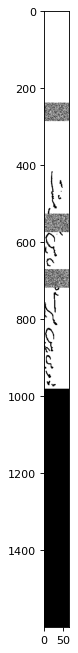

In [ ]:
N = 5
encoding = train_dataset[N]
figure(figsize=(10, 10), dpi=80)

plt.imshow(encoding[0].permute(1,2,0), cmap="gray")

In [ ]:
image = Image.open(train_df['file_name'][N]).convert("RGB")
image

In [ ]:
labels = encoding[1]
labels[labels == -100] = tokenizer.pad_token_id
label_str = tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)

ڈوبی ہیں میرے خون میں یک مشت


In [ ]:
# resize images to maintain the dimensions: (batch_size, 1, 512, 64)
def resize_images(batch_dict, target_height=512, target_width=64):
    """
    Resizes the images in the batch to the specified height and width.

    Args:
        batch_dict (dict): Dictionary containing 'pixel_values' and 'labels'.
        target_height (int): Target height of the images.
        target_width (int): Target width of the images.

    Returns:
        dict: Updated batch_dict with resized 'pixel_values'.
    """
    pixel_values = batch_dict['pixel_values']
    # Resize using interpolate
    resized_pixel_values = F.interpolate(
        pixel_values, size=(target_height, target_width), mode='bilinear', align_corners=False
    )
    batch_dict['pixel_values'] = resized_pixel_values
    return batch_dict

In [ ]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    batch_dict = {}
    for src_sample, tgt_sample in batch:
        if src_sample == None:
            continue
        if tgt_sample == None:
            continue
        src_batch.append(src_sample) #ADDEDLINE
        tgt_batch.append(tgt_sample)

    src_batch = torch.stack(src_batch)

    tgt_batch = pad_sequence(tgt_batch, batch_first = True, padding_value = -100)

    batch_dict['pixel_values'] = src_batch
    batch_dict['labels'] = tgt_batch

    # call resize to fix image dimensions
    batch_dict = resize_images(batch_dict)
    return batch_dict

### Custom Conv. Transformer Model

In [ ]:
def model_conv_transformer(vocab_size):

    class Conv(nn.Module):
        def __init__(self):
            super(Conv, self).__init__()            # 512 * 64

            self.conv1 = nn.Sequential(
                nn.Conv2d(1, 16, 3, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                nn.MaxPool2d(2, 2)      #    256 * 32
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(16, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
                nn.MaxPool2d(2, 2)    # 128 * 16
            )
            self.conv3 = nn.Sequential(
                nn.Conv2d(32, 48, 3, padding=1),
                nn.BatchNorm2d(48),
                nn.LeakyReLU(),
                nn.Conv2d(48, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                nn.MaxPool2d((1, 2), (1, 2)),   # 128 * 8
                nn.Dropout2d(0.2),
            )
            self.conv4 = nn.Sequential(
                nn.Conv2d(64, 96, 3, padding=1),
                nn.BatchNorm2d(96),
                nn.LeakyReLU(),
                nn.Conv2d(96, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                nn.MaxPool2d((1, 2), (1, 2)),    # 128 * 4
                nn.Dropout2d(0.2),
            )
            self.conv5 = nn.Sequential(
                nn.Conv2d(128, 256, 4),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
            )

        def forward(self,
                src: Tensor,
               ):

            src = self.conv1(src)
            # print(x.shape)                                 # (*, 16, 32, 256)
            src = self.conv2(src)
            # print(x.shape)                                 # (*, 32, 16, 128)
            src = self.conv3(src)
            # print(x.shape)                                 # (*, 64, 8, 128)
            src = self.conv4(src)
            # print(x.shape)                                 # (*, 128, 4, 128)
            src = self.conv5(src)
            # print(x.shape)                                 # (*, 256, 1, 125)

            src = src.squeeze(-1)
            src = src.permute((0, 2, 1)).contiguous()        # (*, 125, 256)

            return src


    model_conv = Conv()

    dec = {'vocab_size':vocab_size,
           'n_positions':512,
           'n_embd':256,
           'n_head':4,
           'n_layer':2
           }

    enc = {'vocab_size':vocab_size,
           'num_hidden_layers':2,
           'hidden_size':256,
           'num_attention_heads':4,
           'intermediate_size':1024,
           'hidden_act':'gelu'
           }

    enc_config = RobertaConfig(**enc)
    dec_config = GPT2Config(**dec)

    config = EncoderDecoderConfig.from_encoder_decoder_configs(enc_config, dec_config)
    model_transformer = EncoderDecoderModel(config=config)

    return model_conv, model_transformer

In [ ]:
# LOAD PRETRAINED WEIGHTS
import torch
import zipfile
import os
from transformers import AutoModelForSeq2SeqLM


In [ ]:
!unzip /content/conv_transformer_weights.zip -d /content/

Archive:  /content/conv_transformer_weights.zip
   creating: /content/content/conv_transformer_weights/
   creating: /content/content/conv_transformer_weights/icdar/
  inflating: /content/content/conv_transformer_weights/icdar/conv.pt  
  inflating: /content/content/conv_transformer_weights/icdar/model.safetensors  
  inflating: /content/content/conv_transformer_weights/icdar/config.json  
  inflating: /content/content/conv_transformer_weights/icdar/generation_config.json  


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv, transformer = model_conv_transformer(vocab_size = tokenizer.vocab_size)

# Load the transformer part of the model
transformer = AutoModelForSeq2SeqLM.from_pretrained("./conv_transformer_weights/icdar")

# Load the convolutional model weights
conv.load_state_dict(torch.load("/content/conv_transformer_weights/icdar/conv.pt", map_location=torch.device('cpu')))

conv.to(device)
transformer.to(device)

Config of the encoder: <class 'transformers.models.roberta.modeling_roberta.RobertaModel'> is overwritten by shared encoder config: RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "num_attention_heads": 4,
  "num_hidden_layers": 2,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 261
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 5025

EncoderDecoderModel(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(261, 256, padding_idx=1)
      (position_embeddings): Embedding(512, 256, padding_idx=1)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-1): 2 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm):

### Data Batches

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn = collate_fn)
eval_dataloader = DataLoader(eval_dataset, batch_size = 16, collate_fn = collate_fn)

test_dataloader = DataLoader(test_dataset, batch_size = 16, collate_fn = collate_fn)

### Parameters for Beam Search

In [ ]:
transformer.config.decoder_start_token_id = tokenizer.bos_token_id
transformer.config.pad_token_id = tokenizer.pad_token_id
transformer.config.vocab_size = transformer.config.decoder.vocab_size

# set beam search parameters
transformer.config.eos_token_id = tokenizer.eos_token_id
transformer.config.max_length = 256
transformer.config.early_stopping = False
transformer.config.no_repeat_ngram_size = 0
transformer.config.length_penalty = 1
transformer.config.num_beams = 4
transformer.config.temperature = 1

### Compute Character Error Rate (CER)

In [ ]:
def compute_cer(pred_ids, label_ids):

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    label_ids[label_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    print(pred_str[0])
    print(label_str[0])

    combine = [(x, y) for x, y in zip(pred_str, label_str) if x]

    pred_str = [x for x, y in combine]
    label_str = [y for x, y in combine]

    cer_score = cer.compute(predictions=pred_str, references=label_str)

    return cer_score

### Parameter Setting

In [ ]:
from transformers import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

params = list(conv.parameters()) + list(transformer.parameters())
optimizer = torch.optim.Adam(params, lr = 0.0003, betas = (0.9, 0.98), eps = 1e-9)

num_epochs = 100
num_training_steps = num_epochs * len(train_dataloader)
num_eval_steps = num_epochs * len(eval_dataloader)

print(num_training_steps)


progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_eval_steps))

91400


  0%|          | 0/91400 [00:00<?, ?it/s]

  0%|          | 0/11500 [00:00<?, ?it/s]

### Training

In [ ]:
print("Number of training examples: ", len(train_dataloader))
print("Number of validation examples: ", len(eval_dataset))
print(len(train_dataset.df))  # Check how many rows are in the DataFrame
print(train_dataset.df.index)  # Check the index of the DataFrame

Number of training examples:  914
Number of validation examples:  1827
14616
RangeIndex(start=0, stop=14616, step=1)


In [ ]:
train_dataset.df.reset_index(drop=True, inplace=True)
eval_dataset.df.reset_index(drop=True, inplace=True)

train_losses = []
val_losses = []

In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    # train
    conv.train()
    transformer.train()
    train_loss = 0.0
    eval_loss = 0.0
    correct_train = 0.0
    total_train = 0.0
    correct_eval = 0.0
    total_eval = 0.0
    for batch in train_dataloader:
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = conv(batch['pixel_values'])
        labels = batch['labels']

        outputs = transformer(inputs_embeds=outputs, labels=labels)

        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        with torch.no_grad():
            preds = preds = torch.argmax(logits, axis=-1)
            mask = torch.ones_like(labels).to(device)
            mask[labels==-100] = 0
            correct_train += ((preds == labels)*mask).sum()
            total_train += mask.sum()

        progress_bar_train.update(1)

    # calculate average train loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)  # store train loss for plotting

    # percentage accuracy in train
    train_acc = (correct_train / total_train) * 100
    print(f"Train Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    print(f"Train ACC after epoch {epoch}:", correct_train/total_train)
    print(f"Train Accuracy after epoch {epoch}: {train_acc:.2f}%")

    # evaluate
    conv.eval()
    transformer.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in eval_dataloader:
            for k,v in batch.items():
                batch[k] = v.to(device)

            outputs = conv(batch['pixel_values'])
            labels = batch['labels']

            outputs = transformer(inputs_embeds = outputs, labels=labels)
            logits = outputs.logits
            loss = outputs.loss
            eval_loss += loss.item()

            preds = torch.argmax(logits, axis=-1)
            mask = torch.ones_like(labels).to(device)
            mask[labels==-100] = 0
            correct_eval += ((preds == labels)*mask).sum()
            total_eval += mask.sum()

            progress_bar_eval.update(1)

        # calculate average validation loss for this epoch
        avg_eval_loss = eval_loss / len(eval_dataloader)
        val_losses.append(avg_eval_loss)  # store val loss for plotting

        # percentage accuracy in value
        val_acc = (correct_eval / total_eval) * 100
        print(f"Val Loss after epoch {epoch}:", eval_loss/len(eval_dataloader))
        print(f"Val ACC after epoch {epoch}:", correct_eval/total_eval)
        print(f"Val Accuracy after epoch {epoch}: {val_acc:.2f}%")


        transformer.save_pretrained("./conv_transformer_weights/icdar")
        torch.save(conv.state_dict(), "./conv_transformer_weights/icdar/conv.pt")


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 0: 1.5811042802599902
Train ACC after epoch 0: tensor(0.4358, device='cuda:0')
Train Accuracy after epoch 0: 43.58%
Val Loss after epoch 0: 1.2702003561932107
Val ACC after epoch 0: tensor(0.5338, device='cuda:0')
Val Accuracy after epoch 0: 53.38%


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 256, 'num_beams': 4}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-deco

Train Loss after epoch 1: 1.1885341609985092
Train ACC after epoch 1: tensor(0.5617, device='cuda:0')
Train Accuracy after epoch 1: 56.17%
Val Loss after epoch 1: 1.0473107001055841
Val ACC after epoch 1: tensor(0.6125, device='cuda:0')
Val Accuracy after epoch 1: 61.25%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 2: 1.054776141823512
Train ACC after epoch 2: tensor(0.6098, device='cuda:0')
Train Accuracy after epoch 2: 60.98%
Val Loss after epoch 2: 0.9782133833221768
Val ACC after epoch 2: tensor(0.6356, device='cuda:0')
Val Accuracy after epoch 2: 63.56%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 3: 0.987622214191852
Train ACC after epoch 3: tensor(0.6347, device='cuda:0')
Train Accuracy after epoch 3: 63.47%
Val Loss after epoch 3: 0.9267571335253508
Val ACC after epoch 3: tensor(0.6572, device='cuda:0')
Val Accuracy after epoch 3: 65.72%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 4: 0.9378308225056274
Train ACC after epoch 4: tensor(0.6541, device='cuda:0')
Train Accuracy after epoch 4: 65.41%
Val Loss after epoch 4: 0.8995787827864937
Val ACC after epoch 4: tensor(0.6694, device='cuda:0')
Val Accuracy after epoch 4: 66.94%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 5: 0.9013191352005339
Train ACC after epoch 5: tensor(0.6677, device='cuda:0')
Train Accuracy after epoch 5: 66.77%
Val Loss after epoch 5: 0.8675387035245481
Val ACC after epoch 5: tensor(0.6811, device='cuda:0')
Val Accuracy after epoch 5: 68.11%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 6: 0.8719425207285182
Train ACC after epoch 6: tensor(0.6791, device='cuda:0')
Train Accuracy after epoch 6: 67.91%
Val Loss after epoch 6: 0.8359620050243709
Val ACC after epoch 6: tensor(0.6935, device='cuda:0')
Val Accuracy after epoch 6: 69.35%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 7: 0.8499627598200638
Train ACC after epoch 7: tensor(0.6873, device='cuda:0')
Train Accuracy after epoch 7: 68.73%
Val Loss after epoch 7: 0.8264115229896877
Val ACC after epoch 7: tensor(0.6977, device='cuda:0')
Val Accuracy after epoch 7: 69.77%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 8: 0.8314475086833507
Train ACC after epoch 8: tensor(0.6944, device='cuda:0')
Train Accuracy after epoch 8: 69.44%
Val Loss after epoch 8: 0.8075284263362055
Val ACC after epoch 8: tensor(0.7046, device='cuda:0')
Val Accuracy after epoch 8: 70.46%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 9: 0.8097066021722047
Train ACC after epoch 9: tensor(0.7024, device='cuda:0')
Train Accuracy after epoch 9: 70.24%
Val Loss after epoch 9: 0.7931320794250654
Val ACC after epoch 9: tensor(0.7116, device='cuda:0')
Val Accuracy after epoch 9: 71.16%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 10: 0.7930255666603405
Train ACC after epoch 10: tensor(0.7086, device='cuda:0')
Train Accuracy after epoch 10: 70.86%
Val Loss after epoch 10: 0.7779979273028995
Val ACC after epoch 10: tensor(0.7176, device='cuda:0')
Val Accuracy after epoch 10: 71.76%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 11: 0.7791632472229735
Train ACC after epoch 11: tensor(0.7140, device='cuda:0')
Train Accuracy after epoch 11: 71.40%
Val Loss after epoch 11: 0.7651225346585978
Val ACC after epoch 11: tensor(0.7209, device='cuda:0')
Val Accuracy after epoch 11: 72.09%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 12: 0.7656250119013651
Train ACC after epoch 12: tensor(0.7189, device='cuda:0')
Train Accuracy after epoch 12: 71.89%
Val Loss after epoch 12: 0.755632697240166
Val ACC after epoch 12: tensor(0.7268, device='cuda:0')
Val Accuracy after epoch 12: 72.68%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 13: 0.7520034813385302
Train ACC after epoch 13: tensor(0.7236, device='cuda:0')
Train Accuracy after epoch 13: 72.36%
Val Loss after epoch 13: 0.7419849802618441
Val ACC after epoch 13: tensor(0.7300, device='cuda:0')
Val Accuracy after epoch 13: 73.00%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 14: 0.7431969027680955
Train ACC after epoch 14: tensor(0.7270, device='cuda:0')
Train Accuracy after epoch 14: 72.70%
Val Loss after epoch 14: 0.7548847325470136
Val ACC after epoch 14: tensor(0.7307, device='cuda:0')
Val Accuracy after epoch 14: 73.07%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 15: 0.7353059758699175
Train ACC after epoch 15: tensor(0.7304, device='cuda:0')
Train Accuracy after epoch 15: 73.04%
Val Loss after epoch 15: 0.7253714162370433
Val ACC after epoch 15: tensor(0.7366, device='cuda:0')
Val Accuracy after epoch 15: 73.66%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 16: 0.723961512454229
Train ACC after epoch 16: tensor(0.7346, device='cuda:0')
Train Accuracy after epoch 16: 73.46%
Val Loss after epoch 16: 0.7178994448288627
Val ACC after epoch 16: tensor(0.7409, device='cuda:0')
Val Accuracy after epoch 16: 74.09%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 17: 0.7136344103309727
Train ACC after epoch 17: tensor(0.7382, device='cuda:0')
Train Accuracy after epoch 17: 73.82%
Val Loss after epoch 17: 0.7106109282244807
Val ACC after epoch 17: tensor(0.7450, device='cuda:0')
Val Accuracy after epoch 17: 74.50%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 18: 0.7039776304553322
Train ACC after epoch 18: tensor(0.7420, device='cuda:0')
Train Accuracy after epoch 18: 74.20%
Val Loss after epoch 18: 0.7018919638965441
Val ACC after epoch 18: tensor(0.7481, device='cuda:0')
Val Accuracy after epoch 18: 74.81%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 19: 0.6952812245168624
Train ACC after epoch 19: tensor(0.7447, device='cuda:0')
Train Accuracy after epoch 19: 74.47%
Val Loss after epoch 19: 0.6941342960233273
Val ACC after epoch 19: tensor(0.7505, device='cuda:0')
Val Accuracy after epoch 19: 75.05%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 20: 0.688056705947517
Train ACC after epoch 20: tensor(0.7480, device='cuda:0')
Train Accuracy after epoch 20: 74.80%
Val Loss after epoch 20: 0.6905302521975144
Val ACC after epoch 20: tensor(0.7528, device='cuda:0')
Val Accuracy after epoch 20: 75.28%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 21: 0.681612676519012
Train ACC after epoch 21: tensor(0.7503, device='cuda:0')
Train Accuracy after epoch 21: 75.03%
Val Loss after epoch 21: 0.6893750273663065
Val ACC after epoch 21: tensor(0.7526, device='cuda:0')
Val Accuracy after epoch 21: 75.26%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 22: 0.6753371152496964
Train ACC after epoch 22: tensor(0.7528, device='cuda:0')
Train Accuracy after epoch 22: 75.28%
Val Loss after epoch 22: 0.6855250972768535
Val ACC after epoch 22: tensor(0.7547, device='cuda:0')
Val Accuracy after epoch 22: 75.47%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 23: 0.6702368124765171
Train ACC after epoch 23: tensor(0.7547, device='cuda:0')
Train Accuracy after epoch 23: 75.47%
Val Loss after epoch 23: 0.6780007668163466
Val ACC after epoch 23: tensor(0.7583, device='cuda:0')
Val Accuracy after epoch 23: 75.83%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 24: 0.6628874729772626
Train ACC after epoch 24: tensor(0.7570, device='cuda:0')
Train Accuracy after epoch 24: 75.70%
Val Loss after epoch 24: 0.6801242294518844
Val ACC after epoch 24: tensor(0.7602, device='cuda:0')
Val Accuracy after epoch 24: 76.02%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 25: 0.6573208726013254
Train ACC after epoch 25: tensor(0.7594, device='cuda:0')
Train Accuracy after epoch 25: 75.94%
Val Loss after epoch 25: 0.672481203597525
Val ACC after epoch 25: tensor(0.7608, device='cuda:0')
Val Accuracy after epoch 25: 76.08%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 26: 0.6523012605615988
Train ACC after epoch 26: tensor(0.7610, device='cuda:0')
Train Accuracy after epoch 26: 76.10%
Val Loss after epoch 26: 0.6717959201854208
Val ACC after epoch 26: tensor(0.7596, device='cuda:0')
Val Accuracy after epoch 26: 75.96%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 27: 0.6461987880504888
Train ACC after epoch 27: tensor(0.7632, device='cuda:0')
Train Accuracy after epoch 27: 76.32%
Val Loss after epoch 27: 0.665183155692142
Val ACC after epoch 27: tensor(0.7647, device='cuda:0')
Val Accuracy after epoch 27: 76.47%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 28: 0.6420733538380858
Train ACC after epoch 28: tensor(0.7647, device='cuda:0')
Train Accuracy after epoch 28: 76.47%
Val Loss after epoch 28: 0.6635990544505741
Val ACC after epoch 28: tensor(0.7648, device='cuda:0')
Val Accuracy after epoch 28: 76.48%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 29: 0.637960794196348
Train ACC after epoch 29: tensor(0.7661, device='cuda:0')
Train Accuracy after epoch 29: 76.61%
Val Loss after epoch 29: 0.6611675075862719
Val ACC after epoch 29: tensor(0.7671, device='cuda:0')
Val Accuracy after epoch 29: 76.71%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 30: 0.6345008580050792
Train ACC after epoch 30: tensor(0.7679, device='cuda:0')
Train Accuracy after epoch 30: 76.79%
Val Loss after epoch 30: 0.658837887774343
Val ACC after epoch 30: tensor(0.7678, device='cuda:0')
Val Accuracy after epoch 30: 76.78%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 31: 0.6290440171044035
Train ACC after epoch 31: tensor(0.7694, device='cuda:0')
Train Accuracy after epoch 31: 76.94%
Val Loss after epoch 31: 0.6586777803690537
Val ACC after epoch 31: tensor(0.7670, device='cuda:0')
Val Accuracy after epoch 31: 76.70%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 32: 0.6264928198649795
Train ACC after epoch 32: tensor(0.7705, device='cuda:0')
Train Accuracy after epoch 32: 77.05%
Val Loss after epoch 32: 0.6580169076504915
Val ACC after epoch 32: tensor(0.7687, device='cuda:0')
Val Accuracy after epoch 32: 76.87%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 33: 0.6227670132918223
Train ACC after epoch 33: tensor(0.7715, device='cuda:0')
Train Accuracy after epoch 33: 77.15%
Val Loss after epoch 33: 0.6507861686789471
Val ACC after epoch 33: tensor(0.7704, device='cuda:0')
Val Accuracy after epoch 33: 77.04%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 34: 0.6194602151603094
Train ACC after epoch 34: tensor(0.7726, device='cuda:0')
Train Accuracy after epoch 34: 77.26%
Val Loss after epoch 34: 0.6550745064797608
Val ACC after epoch 34: tensor(0.7693, device='cuda:0')
Val Accuracy after epoch 34: 76.93%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 35: 0.6153959744575248
Train ACC after epoch 35: tensor(0.7740, device='cuda:0')
Train Accuracy after epoch 35: 77.40%
Val Loss after epoch 35: 0.6576818461003511
Val ACC after epoch 35: tensor(0.7707, device='cuda:0')
Val Accuracy after epoch 35: 77.07%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 36: 0.6127384128273186
Train ACC after epoch 36: tensor(0.7754, device='cuda:0')
Train Accuracy after epoch 36: 77.54%
Val Loss after epoch 36: 0.6516504479491192
Val ACC after epoch 36: tensor(0.7717, device='cuda:0')
Val Accuracy after epoch 36: 77.17%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 37: 0.6088768147111461
Train ACC after epoch 37: tensor(0.7766, device='cuda:0')
Train Accuracy after epoch 37: 77.66%
Val Loss after epoch 37: 0.6536947304787843
Val ACC after epoch 37: tensor(0.7709, device='cuda:0')
Val Accuracy after epoch 37: 77.09%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 38: 0.6060815158114652
Train ACC after epoch 38: tensor(0.7775, device='cuda:0')
Train Accuracy after epoch 38: 77.75%
Val Loss after epoch 38: 0.6481323617955913
Val ACC after epoch 38: tensor(0.7733, device='cuda:0')
Val Accuracy after epoch 38: 77.33%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 39: 0.6024434403139339
Train ACC after epoch 39: tensor(0.7787, device='cuda:0')
Train Accuracy after epoch 39: 77.87%
Val Loss after epoch 39: 0.6477725503237352
Val ACC after epoch 39: tensor(0.7731, device='cuda:0')
Val Accuracy after epoch 39: 77.31%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 40: 0.6011392174520952
Train ACC after epoch 40: tensor(0.7793, device='cuda:0')
Train Accuracy after epoch 40: 77.93%
Val Loss after epoch 40: 0.6456104967905127
Val ACC after epoch 40: tensor(0.7747, device='cuda:0')
Val Accuracy after epoch 40: 77.47%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 41: 0.5975456803026293
Train ACC after epoch 41: tensor(0.7803, device='cuda:0')
Train Accuracy after epoch 41: 78.03%
Val Loss after epoch 41: 0.6483034566692684
Val ACC after epoch 41: tensor(0.7744, device='cuda:0')
Val Accuracy after epoch 41: 77.44%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 42: 0.5957998462526751
Train ACC after epoch 42: tensor(0.7813, device='cuda:0')
Train Accuracy after epoch 42: 78.13%
Val Loss after epoch 42: 0.6490821719169617
Val ACC after epoch 42: tensor(0.7746, device='cuda:0')
Val Accuracy after epoch 42: 77.46%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 43: 0.594026538569896
Train ACC after epoch 43: tensor(0.7819, device='cuda:0')
Train Accuracy after epoch 43: 78.19%
Val Loss after epoch 43: 0.6494105621524479
Val ACC after epoch 43: tensor(0.7747, device='cuda:0')
Val Accuracy after epoch 43: 77.47%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 44: 0.5902454937182579
Train ACC after epoch 44: tensor(0.7830, device='cuda:0')
Train Accuracy after epoch 44: 78.30%
Val Loss after epoch 44: 0.641854743335558
Val ACC after epoch 44: tensor(0.7755, device='cuda:0')
Val Accuracy after epoch 44: 77.55%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 45: 0.5893864120057166
Train ACC after epoch 45: tensor(0.7833, device='cuda:0')
Train Accuracy after epoch 45: 78.33%
Val Loss after epoch 45: 0.6520354447157487
Val ACC after epoch 45: tensor(0.7743, device='cuda:0')
Val Accuracy after epoch 45: 77.43%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 46: 0.5871709388572747
Train ACC after epoch 46: tensor(0.7840, device='cuda:0')
Train Accuracy after epoch 46: 78.40%
Val Loss after epoch 46: 0.6469692155070926
Val ACC after epoch 46: tensor(0.7747, device='cuda:0')
Val Accuracy after epoch 46: 77.47%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 47: 0.5837256775056247
Train ACC after epoch 47: tensor(0.7854, device='cuda:0')
Train Accuracy after epoch 47: 78.54%
Val Loss after epoch 47: 0.646700136039568
Val ACC after epoch 47: tensor(0.7759, device='cuda:0')
Val Accuracy after epoch 47: 77.59%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 48: 0.5811934896970995
Train ACC after epoch 48: tensor(0.7862, device='cuda:0')
Train Accuracy after epoch 48: 78.62%
Val Loss after epoch 48: 0.6448589952095695
Val ACC after epoch 48: tensor(0.7773, device='cuda:0')
Val Accuracy after epoch 48: 77.73%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 49: 0.5791142899502288
Train ACC after epoch 49: tensor(0.7868, device='cuda:0')
Train Accuracy after epoch 49: 78.68%
Val Loss after epoch 49: 0.6455913758796195
Val ACC after epoch 49: tensor(0.7764, device='cuda:0')
Val Accuracy after epoch 49: 77.64%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 50: 0.5777542291767488
Train ACC after epoch 50: tensor(0.7872, device='cuda:0')
Train Accuracy after epoch 50: 78.72%
Val Loss after epoch 50: 0.6480459817077803
Val ACC after epoch 50: tensor(0.7765, device='cuda:0')
Val Accuracy after epoch 50: 77.65%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 51: 0.5765785204177352
Train ACC after epoch 51: tensor(0.7880, device='cuda:0')
Train Accuracy after epoch 51: 78.80%
Val Loss after epoch 51: 0.6493990493857342
Val ACC after epoch 51: tensor(0.7762, device='cuda:0')
Val Accuracy after epoch 51: 77.62%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 52: 0.573719219481919
Train ACC after epoch 52: tensor(0.7887, device='cuda:0')
Train Accuracy after epoch 52: 78.87%
Val Loss after epoch 52: 0.6511418542136317
Val ACC after epoch 52: tensor(0.7769, device='cuda:0')
Val Accuracy after epoch 52: 77.69%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 53: 0.571504834444309
Train ACC after epoch 53: tensor(0.7896, device='cuda:0')
Train Accuracy after epoch 53: 78.96%
Val Loss after epoch 53: 0.6474035545535709
Val ACC after epoch 53: tensor(0.7757, device='cuda:0')
Val Accuracy after epoch 53: 77.57%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 54: 0.5698173156648026
Train ACC after epoch 54: tensor(0.7904, device='cuda:0')
Train Accuracy after epoch 54: 79.04%
Val Loss after epoch 54: 0.6524761238823766
Val ACC after epoch 54: tensor(0.7773, device='cuda:0')
Val Accuracy after epoch 54: 77.73%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 55: 0.5685330824335503
Train ACC after epoch 55: tensor(0.7908, device='cuda:0')
Train Accuracy after epoch 55: 79.08%
Val Loss after epoch 55: 0.6511604817017265
Val ACC after epoch 55: tensor(0.7766, device='cuda:0')
Val Accuracy after epoch 55: 77.66%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 56: 0.5657387070634955
Train ACC after epoch 56: tensor(0.7917, device='cuda:0')
Train Accuracy after epoch 56: 79.17%
Val Loss after epoch 56: 0.6462326301180799
Val ACC after epoch 56: tensor(0.7765, device='cuda:0')
Val Accuracy after epoch 56: 77.65%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 57: 0.5638418841609809
Train ACC after epoch 57: tensor(0.7921, device='cuda:0')
Train Accuracy after epoch 57: 79.21%
Val Loss after epoch 57: 0.6461069169251815
Val ACC after epoch 57: tensor(0.7787, device='cuda:0')
Val Accuracy after epoch 57: 77.87%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 58: 0.5625679711739918
Train ACC after epoch 58: tensor(0.7928, device='cuda:0')
Train Accuracy after epoch 58: 79.28%
Val Loss after epoch 58: 0.6481436379577803
Val ACC after epoch 58: tensor(0.7786, device='cuda:0')
Val Accuracy after epoch 58: 77.86%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 59: 0.5617068403398443
Train ACC after epoch 59: tensor(0.7931, device='cuda:0')
Train Accuracy after epoch 59: 79.31%
Val Loss after epoch 59: 0.657705738492634
Val ACC after epoch 59: tensor(0.7778, device='cuda:0')
Val Accuracy after epoch 59: 77.78%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 60: 0.5589096683283342
Train ACC after epoch 60: tensor(0.7936, device='cuda:0')
Train Accuracy after epoch 60: 79.36%
Val Loss after epoch 60: 0.6473487716654073
Val ACC after epoch 60: tensor(0.7796, device='cuda:0')
Val Accuracy after epoch 60: 77.96%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 61: 0.5587613522289097
Train ACC after epoch 61: tensor(0.7942, device='cuda:0')
Train Accuracy after epoch 61: 79.42%
Val Loss after epoch 61: 0.6465318241845006
Val ACC after epoch 61: tensor(0.7784, device='cuda:0')
Val Accuracy after epoch 61: 77.84%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 62: 0.5576733425096557
Train ACC after epoch 62: tensor(0.7946, device='cuda:0')
Train Accuracy after epoch 62: 79.46%
Val Loss after epoch 62: 0.6473586196484773
Val ACC after epoch 62: tensor(0.7776, device='cuda:0')
Val Accuracy after epoch 62: 77.76%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 63: 0.5550186271805732
Train ACC after epoch 63: tensor(0.7954, device='cuda:0')
Train Accuracy after epoch 63: 79.54%
Val Loss after epoch 63: 0.6523086089154948
Val ACC after epoch 63: tensor(0.7775, device='cuda:0')
Val Accuracy after epoch 63: 77.75%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 64: 0.5537382328568976
Train ACC after epoch 64: tensor(0.7956, device='cuda:0')
Train Accuracy after epoch 64: 79.56%
Val Loss after epoch 64: 0.6507270815579788
Val ACC after epoch 64: tensor(0.7797, device='cuda:0')
Val Accuracy after epoch 64: 77.97%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 65: 0.5520914245877798
Train ACC after epoch 65: tensor(0.7964, device='cuda:0')
Train Accuracy after epoch 65: 79.64%
Val Loss after epoch 65: 0.6509120645730392
Val ACC after epoch 65: tensor(0.7788, device='cuda:0')
Val Accuracy after epoch 65: 77.88%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 66: 0.55087228465002
Train ACC after epoch 66: tensor(0.7972, device='cuda:0')
Train Accuracy after epoch 66: 79.72%
Val Loss after epoch 66: 0.6472499917382779
Val ACC after epoch 66: tensor(0.7791, device='cuda:0')
Val Accuracy after epoch 66: 77.91%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 67: 0.5494324025133507
Train ACC after epoch 67: tensor(0.7974, device='cuda:0')
Train Accuracy after epoch 67: 79.74%
Val Loss after epoch 67: 0.650188795639121
Val ACC after epoch 67: tensor(0.7781, device='cuda:0')
Val Accuracy after epoch 67: 77.81%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 68: 0.547885701125508
Train ACC after epoch 68: tensor(0.7984, device='cuda:0')
Train Accuracy after epoch 68: 79.84%
Val Loss after epoch 68: 0.6556587532810543
Val ACC after epoch 68: tensor(0.7783, device='cuda:0')
Val Accuracy after epoch 68: 77.83%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 69: 0.547871112595241
Train ACC after epoch 69: tensor(0.7981, device='cuda:0')
Train Accuracy after epoch 69: 79.81%
Val Loss after epoch 69: 0.6524323217246843
Val ACC after epoch 69: tensor(0.7795, device='cuda:0')
Val Accuracy after epoch 69: 77.95%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 70: 0.5455645167918904
Train ACC after epoch 70: tensor(0.7987, device='cuda:0')
Train Accuracy after epoch 70: 79.87%
Val Loss after epoch 70: 0.6553578664427219
Val ACC after epoch 70: tensor(0.7789, device='cuda:0')
Val Accuracy after epoch 70: 77.89%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 71: 0.5438473711780698
Train ACC after epoch 71: tensor(0.7993, device='cuda:0')
Train Accuracy after epoch 71: 79.93%
Val Loss after epoch 71: 0.6517906080121579
Val ACC after epoch 71: tensor(0.7785, device='cuda:0')
Val Accuracy after epoch 71: 77.85%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 72: 0.5436931592565136
Train ACC after epoch 72: tensor(0.7994, device='cuda:0')
Train Accuracy after epoch 72: 79.94%
Val Loss after epoch 72: 0.6628206719522891
Val ACC after epoch 72: tensor(0.7789, device='cuda:0')
Val Accuracy after epoch 72: 77.89%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 73: 0.5414743682357362
Train ACC after epoch 73: tensor(0.8003, device='cuda:0')
Train Accuracy after epoch 73: 80.03%
Val Loss after epoch 73: 0.6483741630678591
Val ACC after epoch 73: tensor(0.7794, device='cuda:0')
Val Accuracy after epoch 73: 77.94%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 74: 0.5406519614763281
Train ACC after epoch 74: tensor(0.8005, device='cuda:0')
Train Accuracy after epoch 74: 80.05%
Val Loss after epoch 74: 0.6533102880353513
Val ACC after epoch 74: tensor(0.7779, device='cuda:0')
Val Accuracy after epoch 74: 77.79%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 75: 0.5391319275424047
Train ACC after epoch 75: tensor(0.8012, device='cuda:0')
Train Accuracy after epoch 75: 80.12%
Val Loss after epoch 75: 0.6492564960666325
Val ACC after epoch 75: tensor(0.7791, device='cuda:0')
Val Accuracy after epoch 75: 77.91%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 76: 0.538005381203063
Train ACC after epoch 76: tensor(0.8014, device='cuda:0')
Train Accuracy after epoch 76: 80.14%
Val Loss after epoch 76: 0.6509754841742308
Val ACC after epoch 76: tensor(0.7803, device='cuda:0')
Val Accuracy after epoch 76: 78.03%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 77: 0.5380322011574875
Train ACC after epoch 77: tensor(0.8019, device='cuda:0')
Train Accuracy after epoch 77: 80.19%
Val Loss after epoch 77: 0.6577487968880197
Val ACC after epoch 77: tensor(0.7781, device='cuda:0')
Val Accuracy after epoch 77: 77.81%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 78: 0.5370262859295443
Train ACC after epoch 78: tensor(0.8017, device='cuda:0')
Train Accuracy after epoch 78: 80.17%
Val Loss after epoch 78: 0.6542997000010117
Val ACC after epoch 78: tensor(0.7800, device='cuda:0')
Val Accuracy after epoch 78: 78.00%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 79: 0.5358243888851328
Train ACC after epoch 79: tensor(0.8020, device='cuda:0')
Train Accuracy after epoch 79: 80.20%
Val Loss after epoch 79: 0.6590636294821034
Val ACC after epoch 79: tensor(0.7793, device='cuda:0')
Val Accuracy after epoch 79: 77.93%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 80: 0.5336351631539394
Train ACC after epoch 80: tensor(0.8030, device='cuda:0')
Train Accuracy after epoch 80: 80.30%
Val Loss after epoch 80: 0.6597058625324913
Val ACC after epoch 80: tensor(0.7793, device='cuda:0')
Val Accuracy after epoch 80: 77.93%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Train Loss after epoch 81: 0.5321946090466345
Train ACC after epoch 81: tensor(0.8034, device='cuda:0')
Train Accuracy after epoch 81: 80.34%
Val Loss after epoch 81: 0.6529991370180379
Val ACC after epoch 81: tensor(0.7807, device='cuda:0')
Val Accuracy after epoch 81: 78.07%


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [ ]:
# Plot the loss graph after training
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [ ]:
print(batch["pixel_values"].shape, batch["labels"].shape)
print(batch["labels"].max(), transformer.config.vocab_size)
assert batch["labels"].max().item() < transformer.config.vocab_size, "Token ID out of range!"


print("Transformer vocab size:", transformer.config.vocab_size)
print("Tokenizer vocab size:", tokenizer.vocab_size)


Transformer vocab size: 261
Tokenizer vocab size: 261


In [ ]:
# Print dataloader values
# Loop over the test_dataloader to print the first batch of data
counter = 0
for batch in tqdm(test_dataloader):
    # Print the shapes and contents of pixel_values and labels
    print("Batch keys:", batch.keys())  # Check the keys to see what is inside the batch
    print("Pixel values shape:", batch["pixel_values"].shape)
    print("Labels shape:", batch["labels"].shape)
    print(f"Pixel values ({counter} item):", batch["pixel_values"][0])  # Print first pixel values
    print(f"Labels ({counter} item):", batch["labels"][0])  # Print first label
    counter += 1
    break  # Exit after printing the first batch


  0%|          | 0/115 [00:00<?, ?it/s]

Batch keys: dict_keys(['pixel_values', 'labels'])
Pixel values shape: torch.Size([16, 1, 512, 64])
Labels shape: torch.Size([16, 140])
Pixel values (0 item): tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Labels (0 item): tensor([   0,  155,  107,  156,  239,  225,  153,  117,  153,  105,  154,  233,
         153,  112,  153,  105,  153,  114,  153,  108,  153,  118,  153,  105,
         154,  235,  156,  239,  153,  114,  225,  153,  105,  154,  242,  153,
         108,  153,  105,  153,  114,  156,  239,  155,  123,  156,  228,    2,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
   

In [ ]:
test_dataset.df.reset_index(drop=True, inplace=True)

In [ ]:
for batch in tqdm(test_dataloader):
    print("Batch keys:", batch.keys())  # Check the keys to see what is inside the batch

  0%|          | 0/115 [00:00<?, ?it/s]

Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])
Batch keys: dict_keys(['pixel_values', 'labels'])


In [ ]:
conv.eval()
transformer.eval()
test_cer = 0.0
data_loader = test_dataloader
cer_list = []
with torch.no_grad():
    for batch in tqdm(data_loader):
        # run batch generation
        outputs = conv(batch["pixel_values"].to(device))
        outputs = transformer.generate(inputs_embeds = outputs)
        # compute metrics
        error = compute_cer(pred_ids = outputs, label_ids = batch["labels"])
        test_cer += error
        cer_list.append(error)

print("Validation CER:", test_cer / len(data_loader))



  0%|          | 0/115 [00:00<?, ?it/s]

  1%|          | 1/115 [00:02<03:57,  2.09s/it]

کے لیے ایک ہفتہ درکار ہوتا ہے؟روس کی ٹرانس سائبرین ریلوے ایسی سنگل
کی شاندارتصاویر اُتاریںہ




  2%|▏         | 2/115 [00:04<04:10,  2.22s/it]

میں اس کے ساتھ ساتھ ساتھ ساتھ ساتھ رہا ہے کہ انہیں
بلین ڈالر کے درآمدات کے ہدف، سہولیاتی پالیسی کے35




  3%|▎         | 3/115 [00:06<03:59,  2.14s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے




  3%|▎         | 4/115 [00:08<03:42,  2.01s/it]

میں امریکی میں موجود ہوتی ہے۔ اس میں امریکی میں موجودہ حکومت کے مطابق
ہے وابستگی سےانہیں طاقت نہیں ملے گی لیکن اگراسلامی حکومتیں امت




  4%|▍         | 5/115 [00:10<03:31,  1.92s/it]

میں امریکہ میں منصوبوں میں امریکی میں اضافہ کیا گیا
نیم پختہ کمرے اور برآمدے میں الائو... اللہ اللہ! انہی ٹیلوں کے




  5%|▌         | 6/115 [00:11<03:23,  1.87s/it]

میں اس کے ساتھ ساتھ ساتھ ساتھ کر رہے ہیں
ہے۔ قوت ثقل واقعی توانائی کی ایک قسم ہے جو کہ




  6%|▌         | 7/115 [00:13<03:17,  1.83s/it]

میں ان کے ساتھ ساتھ اور اس کے علاوہ اندازہ کیا جاسکتا ہے۔
بلین روپے مختص کئے گئے ہیں نیپ کیلئے30 ارب پی ایس ڈی پی820




  7%|▋         | 8/115 [00:15<03:13,  1.81s/it]

میں امریکہ میں منصوبے کے باعث پیداواری کے لئے اس کی معاشرے میں
کے نئے موقع پیدا ہوں گے۔ پنجاب میں بیرونی سرمای کاری




  8%|▊         | 9/115 [00:17<03:31,  1.99s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
ہمارے پاس تھوڑا بہت علم ضرور ہے کہ ہم جان سکیں کہ بِیتے ادوار میں




  9%|▊         | 10/115 [00:19<03:29,  2.00s/it]

اور اس کے ساتھ ساتھ ساتھ ملک میں موجود ہیں۔ انہوں نے کہا کہ
معلو م ہوتا مگر تیری عبادت کے ساتھ اور دنیا اچھی نہیں معلو م ہوتی




 10%|▉         | 11/115 [00:21<03:21,  1.94s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
ہے اور ہر شعبہ زندگی اس کو اپنا رہا ہے۔ گرڈ کی بجلی جس کا




 10%|█         | 12/115 [00:23<03:18,  1.93s/it]

﻿پاکستان کےنعرےپاکستان کامطلب کیا 'لاالہ الااللہ' میں مرغ بادنما
﻿سر علامہ محمد اقبال نے ١٩٣٠ میں علیحدہ ریاست کے قیام کا خیال پیش




 11%|█▏        | 13/115 [00:25<03:12,  1.89s/it]

اور اس کے ساتھ سے معلوم ہوتا ہے اور
تھکا ہو ا ہے ، اسکو آرام پہنچانے کے لئے




 12%|█▏        | 14/115 [00:27<03:14,  1.93s/it]

میں امریکہ میں منصوبوں کو اپنے مزید کہتے ہیں کہ ماحول کرنے کیلئے
اپنی زندگیاں دین کی راہ میں صرف کیں جس کی بدولت تعلیمی اداروں




 13%|█▎        | 15/115 [00:29<03:19,  2.00s/it]

میں ان کے ساتھ ساتھ اور اس کے علاوہ اپنے ملازمین کی تعمیر کردیا
فاتح واشنگٹن قرار دے رہے ہیں کیری لوگر بل کے ذریعے حکمرانوں




 14%|█▍        | 16/115 [00:31<03:24,  2.07s/it]

اور اس کے ساتھ ساتھ کر رہے ہیں اور ان کا کہنا
!گئے ہیں؟ انھوں نے کہا ہاں تو کہا گیا کہ مرحبا




 15%|█▍        | 17/115 [00:33<03:13,  1.97s/it]

میں اس کے ساتھ ساتھ معلوم ہوتے ہیں اور اس کے بارے میں
چاروں طرف جدھر دیکھو خستہ حال انسان تھے۔ چہرے




 16%|█▌        | 18/115 [00:35<03:03,  1.89s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿١٨٥٧ کی جنگ آذادی کے بعد مسلمانوں میں احساس محرومی وقت کے




 17%|█▋        | 19/115 [00:36<02:57,  1.85s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
کی سطح پر لانے کی تجویز کی بھی منظوری دی، جس سے تیل اور گیس




 17%|█▋        | 20/115 [00:38<02:53,  1.83s/it]

اور اس کے ساتھ ساتھ ساتھ ساتھ ساتھ لیجیے
کر دیا۔ اس لیئے کہ تجارت میں اس کو زیادہ




 18%|█▊        | 21/115 [00:40<02:50,  1.81s/it]

اور اس کے ساتھ ساتھ ساتھ ساتھ
کہ آنکھ اس کی اک پل پڑے تو مرے




 19%|█▉        | 22/115 [00:42<02:59,  1.93s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
فائبر، میگنیشم اور آئرن فراہم کرتے ہیں۔اس کے علاوہ دھنیے میں




 20%|██        | 23/115 [00:45<03:12,  2.09s/it]

کے لیے ایک ہفتہ درکار ہوتا ہے؟روس کی ٹرانس سائبرین ریلوے ایسی سنگل
میونسپلٹی کے مطابق اس میوزیم نما پارک میں 12 باغات قائم




 21%|██        | 24/115 [00:46<03:01,  1.99s/it]

اور اس کے ساتھ ساتھ معلوم ہوتا ہے اور اس کے
میں بڑے بڑے ٹی وی چینلوں پر اس حملے کی




 22%|██▏       | 25/115 [00:48<02:51,  1.91s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿١٩٧٩ میں جنرل ضیاءالحق نے اختیارات سے تجاوز کر کے جمہوری حکومت




 23%|██▎       | 26/115 [00:50<02:43,  1.84s/it]

میں اس کے ساتھ ساتھ اور اس کے ساتھ معلوم ہونے والے
کے چھوٹے بھائی پندرہ سالہ محمد منیب سجاد کی الم ناک موت




 23%|██▎       | 27/115 [00:51<02:37,  1.78s/it]

﻿پاکستان کےنعرےپاکستان کامطلب کیا 'لاالہ الااللہ' میں مرغ بادنما
﻿٢٠٠٨ تک پرویز مشرف کا دور رہا۔ پھر پی پی پی آئی اور اب١١ مئ٢٠١٣




 24%|██▍       | 28/115 [00:53<02:36,  1.80s/it]

﻿پر دو قومی نظریہ ٢٣ مارچ ١٩٤٠  کو قرارداد لاہور میں قائداعظم محمد علی
﻿کےمعرض وجود میں آنےسےپہلےمسلمانوں کے سیاسی دور کا آغاذ




 25%|██▌       | 29/115 [00:55<02:42,  1.89s/it]

میں امریکی ترقی کے ساتھ ساتھ ساتھ ہوتی ہے اور اس کے مطابق
مولانا محمد حسن فیضی مرزا کے بلند بانگ دعوے سن کر 13فروری 1899کو بنفس نفیس




 26%|██▌       | 30/115 [00:58<02:51,  2.02s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿کون سوچ سکتا تھا کہ ہندوستان اکثریت اورانگریزحکمرانوں کی مشترکہ




 27%|██▋       | 31/115 [00:59<02:42,  1.94s/it]

اور اس کے ساتھ ساتھ ساتھ ساتھ
ناکامیوں سے کام رکھا میں تمام عمر




 28%|██▊       | 32/115 [01:02<03:02,  2.20s/it]

میں امریکی میں منصوبے کے ساتھ ساتھ ساتھ سال کرنے والوں میں
میں ہوئی شہادتوں نے ایک بار پھرہمارے موقف کو تقویت پہنچائی ہے




 29%|██▊       | 33/115 [01:04<02:47,  2.04s/it]

میں امریکی اور اس کے ساتھ ساتھ کر رہی ہے۔ اس کے مطابق
دیگر نے بھی خطاب کیا۔ جماعت علی شاہ نے کہا




 30%|██▉       | 34/115 [01:06<02:36,  1.93s/it]

میں امریکی میں موجود ہوتی ہے۔ اس کے علاوہ اس کی معاشرے میں
کا سامنا کرنا پڑے گا۔ بھارت کے لئے یہ بات انتہائی شرمناک




 30%|███       | 35/115 [01:07<02:29,  1.87s/it]

میں امریکی میں اضافہ کرتے ہوئے ہیں۔ انہوں نے کہا کہ معاملات
بھی وہ اس کی طرف نہیں جاتا اور بھاگ پڑتا ہے۔ ''ڈرپوک'' ہیرو زندگی




 31%|███▏      | 36/115 [01:10<02:46,  2.10s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
جو افراد ابلتی ہوئی تیز گرم چائے پینے کے عادی ہیں ان میں غذائی




 32%|███▏      | 37/115 [01:12<02:40,  2.06s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
ان کی نظر میں۔اکتوبر 1504ء بابر کے لیے ایک اچھا وقت تھا۔ اِسی برس




 33%|███▎      | 38/115 [01:14<02:32,  1.98s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
نئے قانون میں لفاظی کے علاوہ کچھ زیادہ تبدیلی نہیں کی گئی۔ کفالہ کے سسٹم




 34%|███▍      | 39/115 [01:15<02:25,  1.91s/it]

کے لیے ایک ہفتہ درکار ہوتا ہے؟روس کی ٹرانس سائبرین ریلوے ایسی سنگل
5 سال میں 120 گائے مرچکی ہیں‘۔پیٹرک لی کا کہنا تھا کہ جانوروں کے ڈاکٹر




 35%|███▍      | 40/115 [01:17<02:20,  1.87s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿کون سوچ سکتا تھا کہ ہندوستان اکثریت اورانگریزحکمرانوں کی مشترکہ




 36%|███▌      | 41/115 [01:19<02:16,  1.84s/it]

ملانے والی مرکزی شاهراه پر کرفیو نافذ کر دیا گیا هے
نے اس خریداری کی منظوری دی هے




 37%|███▋      | 42/115 [01:21<02:13,  1.83s/it]

میں امریکی میں موجود ہوتی ہے۔ اس میں امریکی میں بھی امریکہ میں
شرکت نہیں کرے گی تو اس کے خلاف قانونی چارہ جوئی کی جائے گی۔اس




 37%|███▋      | 43/115 [01:23<02:25,  2.02s/it]

اور اس کے ساتھ ساتھ ساتھ ساتھ ساتھ رہا ہے کہ انہیں
جی آیا صاحب!'' قاسم بھاگتا ہوا پھر اپنے آقا کے پاس گیا۔''




 38%|███▊      | 44/115 [01:25<02:19,  1.97s/it]

اور اس کے ساتھ ساتھ معلوم ہو جاتا ہے اور
تاکہ نقد روپیہ وہ اپنے کام میں لگا سکے۔




 39%|███▉      | 45/115 [01:27<02:14,  1.92s/it]

میں امریکی میں اضافہ کیا گیا ہے۔ انہوں نے کہا کہ انہوں نے
خون کی راہ ہموار ہوچکی ۔ ہو سکتاہے کہ حکومت اپنا وجود




 40%|████      | 46/115 [01:29<02:10,  1.89s/it]

میں امریکی میں اضافہ کرتے ہوئے ہیں۔ انہوں نے کہا کہ انہوں نے کہا کہ
ارفع انسانی خصوصیت کے مثالی مظہر اور جلیل القدر پیکر تھے۔ مولانا صاحبزادہ محمد




 41%|████      | 47/115 [01:30<02:06,  1.86s/it]

اور اس کے مطابق معیشت کا اظہار کرتے ہوئے
بجلی کا بھی شدید بحران ہے جس کے مزید بڑھنے کا




 42%|████▏     | 48/115 [01:32<02:03,  1.85s/it]

میں امریکی میں موجود ہوتی ہے۔ اس میں امریکی میں اضافہ کرتے ہوئے
ذکر اضافہ ہوا ہے لیکن بنیادی سہولتوں کی عدم فراہمی اورتوانائی بحران کے صنعتی




 43%|████▎     | 49/115 [01:35<02:09,  1.97s/it]

میں اسلامی ممالک میں معلومات میں ملاقات کرنے کے لئے معاملات اور استعمال کرنے میں
بھارتی انتخابات :مینڈیٹ ، توقعات اور خدشات بھارت میں عام انتخابات




 43%|████▎     | 50/115 [01:37<02:09,  2.00s/it]

ہوتا جو گرم چائے میں ہوتا ہے۔اگرچہ عالمی ادارہ صحت بھی گرما گرم
جے للیتا کے سوگ میں لوگوں نے سر منڈوانا شروع کر دیا




 44%|████▍     | 51/115 [01:38<02:03,  1.93s/it]

میں امریکی میں موجود ہوتی ہے۔ اس کے علاوہ اس کے ساتھ
اور بورڈ آف ڈائریکٹرز کے رکن رہ چکے ہیں۔ حاجی غنی




 45%|████▌     | 52/115 [01:40<01:57,  1.87s/it]

میں اس کے ساتھ ساتھ معلومات کرنے کے لئے اعتراض کرتے ہیں اور
(دینے والا)(۱۸) (سب کیلئے رحمت اور رزق کے دروازے کھولنے والا) (۱۹




 46%|████▌     | 53/115 [01:43<02:10,  2.10s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿تک جمہوری دور کا آغاززوالفقار علی بھٹو کی قیادت میں شروع ہوا۔




 47%|████▋     | 54/115 [01:45<02:13,  2.20s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
پیٹرک لی نے ذاتی تحقیقات کے نتیجے میں اخذ کیا ہے کہ اکثر پر اسرار




 48%|████▊     | 55/115 [01:48<02:18,  2.30s/it]

اور اس کے ساتھ ساتھ ساتھ ساتھ ساتھ
دشمن کے حسب خواہش دل مدعا ہوا




 49%|████▊     | 56/115 [01:50<02:11,  2.22s/it]

میں امریکی میں اضافہ کرتے ہوئے کہا کہ انہوں نے کہا کہ انہوں نے
سے 25 فیصد اضافہ کردیا گیا۔ اس طرح سارے رمضان المبارک میں نمایاں




 50%|████▉     | 57/115 [01:51<01:59,  2.06s/it]

کے لیے ایک ہفتہ درکار ہوتا ہے؟روس کی ٹرانس سائبرین ریلوے ایسی سنگل
ریڈیکلز خلیات، ڈی این اے اور ان کے افعال کے لیے تباہ کن




 50%|█████     | 58/115 [01:53<01:49,  1.92s/it]

اور اس کے ساتھ ساتھ ساتھ
ڈھوروں کا ہوا تھا حال پتلا




 51%|█████▏    | 59/115 [01:55<01:45,  1.89s/it]

اور اس کے ساتھ ساتھ ساتھ ساتھ ساتھ
ہر حال میں ہے شکر خدا کچھ نہ پوچھئے




 52%|█████▏    | 60/115 [01:57<01:40,  1.83s/it]

میں اس کے ساتھ ساتھ ساتھ کیا جاسکتا ہے اور
کرپٹ لوگوں کو سیاست سے باہر کرنے کے لئے سرکاری




 53%|█████▎    | 61/115 [01:58<01:36,  1.79s/it]

اس کے ساتھ ساتھ ساتھ ساتھ کر رہے ہیں۔
لڑکی میں بھی تو یہ خاصیتیں ہوسکتی ہیں۔




 54%|█████▍    | 62/115 [02:01<01:44,  1.97s/it]

اور اس کے ساتھ سے معلوم ہوتا ہے اور اس کے
کرنا ہو گا ۔ چھوٹے چھوٹے اختلافات کو نظر انداز ہو کر




 55%|█████▍    | 63/115 [02:03<01:45,  2.03s/it]

میں اس کے مطابق معاشرے میں جاتا ہے اور ہمارے
سے اجازت طلب نہیں کی اور نہ آپ ﷺ کے




 56%|█████▌    | 64/115 [02:05<01:39,  1.95s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿اسلام کونظریہ پاکستان کی بنیادقراردیا۔ ١٩٥٤میں الیکشن کےبعدعوامی لیگ




 57%|█████▋    | 65/115 [02:08<01:57,  2.35s/it]

﻿پر دو قومی نظریہ ٢٣ مارچ ١٩٤٠  کو قرارداد لاہور میں قائداعظم محمد علی
﻿جناح نے پیش کیا۔ بلآخر دو قومی نظریے کی بنیاد پر ١٤ اگست ١٩٤٧




 57%|█████▋    | 66/115 [02:11<02:00,  2.47s/it]

اور اس کے ساتھ ساتھ معلوم ہوتا ہے اور اس کے مطابق
ایک افافی تنخواہ دی جا رہی ہے۔ جبکہ انکم ٹیکس کے ادارے




 58%|█████▊    | 67/115 [02:14<02:19,  2.90s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
فورس کی تشکیل کے لیے مزید تفصیلات درکار ہوں گی تاکہ ملک کے مصیبت زدہ




 59%|█████▉    | 68/115 [02:17<02:06,  2.68s/it]

میں اسلامی ممالک میں معلومات میں ملاقات کرنے کے لئے معاملات اور استعمال کرنے میں
شب قدر اور شب بیداری:احادیث نبوی ﷺ میں اس شب مبارکہ کی بہت فضیلتیں وارد




 60%|██████    | 69/115 [02:18<01:50,  2.40s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
ایک کے بعد ایک ہماری مصنوعات غیر اعلانیہ لوڈشیڈنگ اور




 61%|██████    | 70/115 [02:20<01:38,  2.19s/it]

میں امریکی میں موجود ہوتی ہے۔ اس میں امریکی میں کامیابی ہوئی ہے کہ
کرنے والے صارفین کو بل کے ساتھ یہ ودہولدنگ ٹیکس دینا ہوگا۔ بجٹ میں




 62%|██████▏   | 71/115 [02:22<01:32,  2.09s/it]

﻿پر دو قومی نظریہ ٢٣ مارچ ١٩٤٠  کو قرارداد لاہور میں قائداعظم محمد علی
﻿٢٠٠٨ تک پرویز مشرف کا دور رہا۔ پھر پی پی پی آئی اور اب١١ مئ٢٠١٣




 63%|██████▎   | 72/115 [02:24<01:25,  1.99s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
کو لگایا گیا ہے۔’القرآن پارک‘ میں شاہکار فن تعمیر کے ذریعے قرآن




 63%|██████▎   | 73/115 [02:26<01:21,  1.93s/it]

میں اس کے ساتھ ساتھ ساتھ ساتھ ساتھ رہا ہے کہ انہیں
کاموں میں خرچ کریں اورکریں ان نعمتوں کی وجہ




 64%|██████▍   | 74/115 [02:28<01:25,  2.10s/it]

میں اس کے ساتھ ساتھ ساتھ ساتھ ساتھ رہا ہے کہ انہیں
روپے کا بجٹ مختص کیا ہے وہ 5سالوں کے لیے ہوگا اور ضرورت




 65%|██████▌   | 75/115 [02:30<01:20,  2.02s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿کی، جس میں یورپ کی طرز پر پاکستانی آئین بنانے کی دی لیکن




 66%|██████▌   | 76/115 [02:32<01:16,  1.95s/it]

کے لیے ایک ہفتہ درکار ہوتا ہے؟روس کی ٹرانس سائبرین ریلوے ایسی سنگل
مسافر‘ اگرچہ سیاسی پس منظر میں لکھی تھی مگر انسان کا دل حقیقتاً




 67%|██████▋   | 77/115 [02:33<01:11,  1.89s/it]

اس کے ساتھ ساتھ معاملات کر رہے ہیں
کہہ اٹھا میں فکر میں ہوں آج کل




 68%|██████▊   | 78/115 [02:35<01:08,  1.86s/it]

میں اس کے ساتھ ساتھ کر رہے ہیں اور اس کے بارے میں
کرسکا اس لیے کہ میری ملازمت ہی بڑی واہیات قسم




 69%|██████▊   | 79/115 [02:37<01:06,  1.85s/it]

میں اس کے ساتھ ساتھ معلوم ہوتے ہیں اور وہ اپنے منصوبے کا
بھی ایس ایم ایس کے ذریعے ہی کرتے ہیں۔پسندیدہ اشعار،اقوالِ زریں اور




 70%|██████▉   | 80/115 [02:39<01:07,  1.92s/it]

میں اس کے ساتھ ساتھ معلوم ہوتے ہیں اور وہ اپنے منصوبے کا
لیے ہدایت کا دروازہ ہمیشہ ہمیشہ کے لیے بند ہوگیا...پس ضروری




 70%|███████   | 81/115 [02:41<01:09,  2.04s/it]

میں ان کے ساتھ ساتھ اور اس کے ساتھ معلوم ہوتی ہے۔ اس کے
ہیں اور ٹیکسٹائل شعبہ جو ملکی معیشت میں ریڑھ کی ہڈی کا درجہ رکھتا




 71%|███████▏  | 82/115 [02:43<01:05,  2.00s/it]

﻿پاکستان کےنعرےپاکستان کامطلب کیا 'لاالہ الااللہ' میں مرغ بادنما
﻿آل انڈیا مسلم لیگ کا قیام وجود میں آیا۔ مسلم لیگ کے پلیٹ فارم میں




 72%|███████▏  | 83/115 [02:45<01:01,  1.91s/it]

میں اس کے ساتھ ساتھ کر رہے ہیں اور اس کے بارے میں
ہوجائے گی اور موجودہ نظام درہم برہم ہو جائے گا۔




 73%|███████▎  | 84/115 [02:48<01:07,  2.18s/it]

میں امریکی میں منصوبے کے ساتھ ساتھ رہتی ہے۔ اور اس کے مطابق
پرکاش، کنول کپور، پروسن جوشی اور عامر کے قریبی دوست امین اور




 74%|███████▍  | 85/115 [02:50<01:02,  2.08s/it]

کے لیے ایک ہفتہ درکار ہوتا ہے؟روس کی ٹرانس سائبرین ریلوے ایسی سنگل
ہوا تھا۔ یہاں کے سندھ ورکی (کاروباری طبقہ) کافی مشہور رہے ہیں۔




 75%|███████▍  | 86/115 [02:52<00:59,  2.05s/it]

﻿پاکستان کےنعرےپاکستان کامطلب کیا 'لاالہ الااللہ' میں مرغ بادنما
﻿کی، جس میں یورپ کی طرز پر پاکستانی آئین بنانے کی دی لیکن




 76%|███████▌  | 87/115 [02:54<00:59,  2.14s/it]

میں امریکی میں موجود ہوتی ہے۔ اس میں امریکی میں میرے پاکستان
مستقبل کی حکمت عملی طے کرنے کیلئے پاکستان کو ان سوالات کا بغور جائزہ لینا




 77%|███████▋  | 88/115 [02:56<00:55,  2.05s/it]

کے لیے ایک ہفتہ درکار ہوتا ہے؟روس کی ٹرانس سائبرین ریلوے ایسی سنگل
نئے کھلونے سے ہر قسم کی پلاسٹک کی ریپنگ اتار دیجیے




 77%|███████▋  | 89/115 [02:57<00:50,  1.94s/it]

میں امریکی میں موجود ہوتی ہے۔ اس کے علاوہ اس کے ساتھ
بجائے پراپرٹی ٹیکس کی وصولی کیلئے نئی حکمت عملی مرتب کی




 78%|███████▊  | 90/115 [02:59<00:47,  1.90s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿١٩٧٩ میں جنرل ضیاءالحق نے اختیارات سے تجاوز کر کے جمہوری حکومت




 79%|███████▉  | 91/115 [03:01<00:44,  1.86s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿پاکستان میں بڑا مثبت کردار تھا۔




 80%|████████  | 92/115 [03:03<00:40,  1.78s/it]

میں ان کے ساتھ ساتھ اور اس کے علاوہ اندازہ کیا جاسکتا ہے۔
لیے افغانستان کے حقانی اہم ہیں ۔کابل کی یونیورسٹی پر حملہ کر




 81%|████████  | 93/115 [03:05<00:41,  1.87s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿کی، جس میں یورپ کی طرز پر پاکستانی آئین بنانے کی دی لیکن




 82%|████████▏ | 94/115 [03:07<00:40,  1.95s/it]

میں امریکہ میں منصوبوں کے لیے معلوم ہوجائے گا۔ اس کی معلومات
پذیرائی حاصل نہیں کر رہا حالانکہ برآمدات کے فروغ کیلئے ٹریڈ ڈیوپلمنٹ اتھارٹی




 83%|████████▎ | 95/115 [03:09<00:37,  1.87s/it]

کے لیے ایک ہفتہ درکار ہوتا ہے؟روس کی ٹرانس سائبرین ریلوے ایسی سنگل
اپنی زندگیاں ہیں۔ سندھ میں اب بھی بہت کچھ ہے جسے دیکھنے کے لیے مجھے




 83%|████████▎ | 96/115 [03:10<00:34,  1.83s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
لیے فائدہ مند ہوتا ہے اور ان سے ایک مشروب تیار کرکے بدہضمی




 84%|████████▍ | 97/115 [03:12<00:32,  1.81s/it]

ہوتا جو گرم چائے میں ہوتا ہے۔اگرچہ عالمی ادارہ صحت بھی گرما گرم
تک ان کی 2 سو گائیں مرچکی ہیں۔ی بریکک نے کہا کہ ’میں




 85%|████████▌ | 98/115 [03:14<00:30,  1.77s/it]

میں امریکہ میں منصوبوں کو اپنے مزید کہتے ہوئے کہا کہ
کا امکان ہے؟امریکی سیکرٹری خارجہ کی جانب سے پاکستان کو




 86%|████████▌ | 99/115 [03:15<00:28,  1.75s/it]

میں امریکی میں موجود ہوتی ہے اور اس کے بارے میں
کہ اس کی غلط پالسیوں کی وجہ سے مسئلہ کشمیر کی ہیت




 87%|████████▋ | 100/115 [03:18<00:28,  1.88s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿کیا جو مسلمانوں کے حقوق کے تحفظ کے لیے ایک اہم قدم تھا۔ باقاعدہ طور




 88%|████████▊ | 101/115 [03:20<00:28,  2.03s/it]

میں امریکی میں موجود ہوتی ہے۔ اس کے علاوہ اس کی معاشرے میں
وہ دادا تھا یعنی ایک خطرناک غنڈہ۔ لیکن میری سمجھ میں اب بھی نہیںآتا کہ




 89%|████████▊ | 102/115 [03:22<00:25,  1.93s/it]

میں اس کے ساتھ ساتھ اور اس کے ساتھ معلوم ہونے والے
گولے کی مانند ہوتا۔ بارشوں کا سارا نظام بلکہ پورا ہی




 90%|████████▉ | 103/115 [03:23<00:22,  1.89s/it]

میں داخل ہوئے۔‘1508ء کابل میں 17 مارچ کو ’نصیرالدین ہمایوں‘
صورت میں نہ پیا جائے۔لندن میں ہونے والی ایک اور تحقیق میں بتایا گیا تھا




 90%|█████████ | 104/115 [03:25<00:20,  1.85s/it]

میں اسلامی ممالک میں معلومات میں ملاقات کرنے کے لئے اعتماد کرنے والے میں
(کا اعلان کردیاہے اعلامیہ کے مطابق ٹوٹل 6961امیدواروں نے بی کام (پاس




 91%|█████████▏| 105/115 [03:27<00:18,  1.81s/it]

﻿پر دو قومی نظریہ ٢٣ مارچ ١٩٤٠  کو قرارداد لاہور میں قائداعظم محمد علی
﻿ساتھ ساتھ بڑھتا گیا۔ مسلمانوں کے حقوق کے تحفظ کے لیے ١٩٠٤  میں




 92%|█████████▏| 106/115 [03:29<00:16,  1.81s/it]

میں امریکی میں منصوبے کے ساتھ ساتھ ساتھ سال کرنے والوں کے
مسئلہ کشمیر کے ازخود وکیل ہیں۔ بلاشبہ پاکستانی میڈیا کی بھاری اکثریت




 93%|█████████▎| 107/115 [03:31<00:15,  1.92s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿پر اس ملک میں بسنے والے مختلف عناصر کا اتحاد ہےاورپاکستان کی




 94%|█████████▍| 108/115 [03:33<00:14,  2.02s/it]

﻿پاکستان کےنعرےپاکستان کامطلب کیا 'لاالہ الااللہ' میں مرغ بادنما
﻿بعد جنرل الیکشن میں پاکستان پیپلز پارٹی نے کامیابی حاصل کی اور محترمہ




 95%|█████████▍| 109/115 [03:35<00:11,  1.95s/it]

میں امریکی میں موجود ہوتی ہے اور اس کی باتیں اور ان کے
کی وجہ شہریوں میں سائبرکرائم کے قانون اورادارے کے حوالے




 96%|█████████▌| 110/115 [03:37<00:09,  1.89s/it]

میں دریافت کیا گیا کہ جو خواتین دن بھر میں 2 یا اس سے زائد مرتبہ ڈائیٹ
نظر آتا ہے۔فون میں سیکرٹ #7353#* کوڈ کا اندراج کریں، اصلی




 97%|█████████▋| 111/115 [03:39<00:07,  1.86s/it]

میں امریکی میں موجود ہوتی ہے۔ اس کے علاوہ اس کے ساتھ
اعلان میزبان گراہم نورٹن نے کیا ۔ انہوں نے بتا یا کہ جمع ہونے




 97%|█████████▋| 112/115 [03:40<00:05,  1.80s/it]

﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے
﻿کو باہر دھکیل کر اقتدار پر قابض ہوگۓ ۔١٩٨٨ میں ضیاالحق کی وفات کے




 98%|█████████▊| 113/115 [03:42<00:03,  1.77s/it]

میں امریکی ترقی کے ساتھ ساتھ ساتھ ہوتی ہے اور اس کے مطابق
اعلان کیا ہے۔ جس کے تحت آٹا، گھی ، بیسن، دالیں، کھجور، چاول،




 99%|█████████▉| 114/115 [03:44<00:01,  1.95s/it]

اور اس کے ساتھ سے معلوم ہوتا ہے اور اس کی وجہ سے
کسی پر کوئی الزام ثابت نہ ہوجائے اس وقت تک




100%|██████████| 115/115 [03:45<00:00,  1.96s/it]

میں اس کے ساتھ ساتھ معلوم ہوتا ہے اور اس کے مطابق
پاکستان میں ٹیکس کا نظام شیدید کرپشن کا شکار ہے
Validation CER: 0.8185592731799761


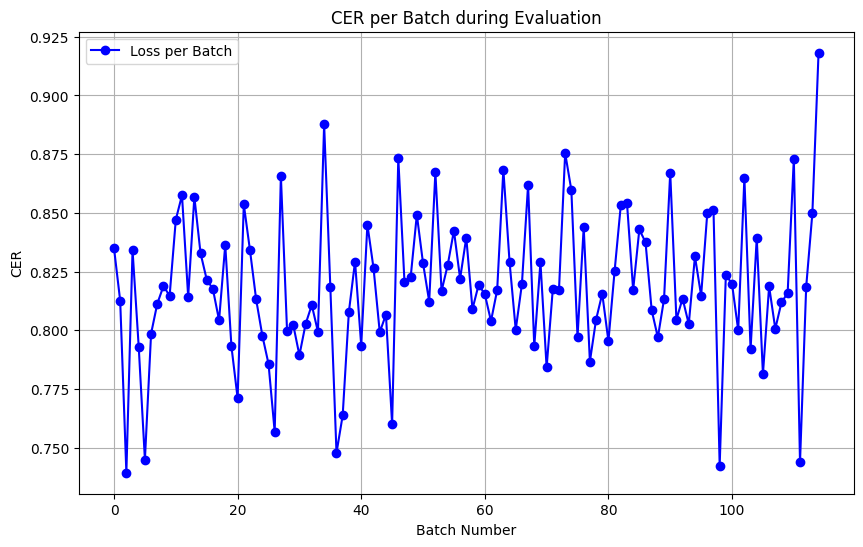

In [ ]:
# Plot the loss graph after evaluation
plt.figure(figsize=(10, 6))
plt.plot(range(len(cer_list)), cer_list, label='Loss per Batch', color='blue', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('CER')
plt.title('CER per Batch during Evaluation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Function to convert CER to loss
def cer_to_loss(cer):
    return 1 - cer  # Convert CER to loss (loss = 1 - CER)

In [ ]:
# Calculate loss per batch
loss_per_batch = [cer_to_loss(cer) for cer in cer_list]

# Plot loss per batch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_per_batch) + 1), loss_per_batch, marker='o', linestyle='-', color='b')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Loss per Batch (based on CER)')
plt.grid(True)
plt.show()

In [ ]:
avg_loss = sum(loss_per_batch) / len(loss_per_batch)
print("Average Loss:", avg_loss)

loss_percentage = avg_loss * 100
print("Average Loss Percentage:", loss_percentage)

Average Loss: 0.18144072682002402
Average Loss Percentage: 18.144072682002403


In [ ]:
# Calculate accuracy from loss
accuracy_list = [1 - loss for loss in loss_per_batch]

# Calculate average accuracy
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
print("Average Accuracy:", avg_accuracy)

# Convert average accuracy to percentage
accuracy_percentage = avg_accuracy * 100
print("Average Accuracy Percentage:", accuracy_percentage)

Average Accuracy: 0.8185592731799761
Average Accuracy Percentage: 81.85592731799761
